In [ ]:
import matplotlib
%matplotlib inline

In [ ]:
import sys

sys.path.append("../image")
import krige

sys.path.append("../radar")
import pyart_utils as pu

In [ ]:
import pandas as pd

In [ ]:
night = "2017-09-30"
next_night = "2017-10-01"
light_levels = df = pd.read_csv("../image/kriged/{}_filtd.csv".format(night))
df["timestamp"] = pd.to_datetime(df["timestamp"])


In [ ]:
light_levels.groupby("timestamp").z.mean().plot()

In [ ]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

In [ ]:
import glob
radar_dir = "-".join(night.split("-")[:2]) + "/" + night.split("-")[-1]
next_radar_dir = "-".join(next_night.split("-")[:2]) + "/" + next_night.split("-")[-1]
print(radar_dir, next_radar_dir)
fnames = glob.glob("../radar/data/{}/*.filtered.csv".format(radar_dir))\
       + glob.glob("../radar/data/{}/*.filtered.csv".format(next_radar_dir))
radar_levels = pd.concat((process_radar_csv(fname)\
                          for fname in fnames))

t_filt = (radar_levels.Date_Time >= "{} 21:00".format(night)) & (radar_levels.Date_Time <= "{} 06:00".format(next_night))
radar_levels = radar_levels[t_filt]

In [ ]:
grouped = radar_levels.groupby(["lon", "lat"])
radar_levels = grouped.apply(lambda g: g.set_index("Date_Time").dbzh.resample('10T').mean().reset_index())\
                   .reset_index()

In [9]:
radar_levels.Date_Time.nunique()

In [10]:
import numpy as np
radar_ixd = radar_levels.set_index("Date_Time").sort_index()
equal_size = radar_ixd.reset_index()
print(equal_size.Date_Time.nunique(), light_levels.timestamp.nunique())
replacement_dict = {k: v for k, v in zip(np.sort(equal_size.Date_Time.unique()), 
                                         np.sort(light_levels.timestamp.unique()))}

karr =  np.array(list(replacement_dict.keys()))

def f(x):
    thing = karr[np.abs(karr - np.datetime64(x)).argmin()]
    return replacement_dict[thing]

equal_size["Date_Time_Join"] = equal_size.Date_Time.astype(np.datetime64).apply(f)

In [11]:
equal_size.shape, light_levels.shape

In [12]:
light_levels['x'].nunique()

In [13]:
mgd = light_levels.merge(equal_size, 
                    left_on=["timestamp", "x", "y"],
                    right_on=["Date_Time_Join", "lon", "lat"])
mgd.shape

In [14]:
np.corrcoef(mgd['dbzh'], mgd["z"])[0,1]

In [15]:
mgd.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot()

In [16]:
mgd.head()

,Unnamed: 0,Unnamed: 0.1,x,y,z,timestamp,geometry,index_right,Date_Time,lon,lat,level_2,dbzh,Date_Time_Join
0,223,223,-74.014080,40.700173,3.939971,2017-09-30 21:00:00,POINT (-74.0140797410063 40.70017257514655),0,2017-09-30 21:00:00,-74.014080,40.700173,0,0.0,2017-09-30 21:00:00
1,224,224,-74.012869,40.700185,3.898995,2017-09-30 21:00:00,POINT (-74.01286857022636 40.7001846163299),0,2017-09-30 21:00:00,-74.012869,40.700185,0,0.0,2017-09-30 21:00:00
2,225,225,-74.011657,40.700197,3.787612,2017-09-30 21:00:00,POINT (-74.0116573990083 40.7001966448284),0,2017-09-30 21:00:00,-74.011657,40.700197,0,0.0,2017-09-30 21:00:00
3,276,276,-74.015307,40.701078,4.094202,2017-09-30 21:00:00,POINT (-74.0153067937795 40.70107825563972),0,2017-09-30 21:00:00,-74.015307,40.701078,0,0.0,2017-09-30 21:00:00
4,277,277,-74.014096,40.701090,3.938574,2017-09-30 21:00:00,POINT (-74.0140956067373 40.70109030974864),0,2017-09-30 21:00:00,-74.014096,40.701090,0,0.0,2017-09-30 21:00:00


In [17]:
def fancy_plot(df):
    fig = plt.figure(figsize=(10,7),facecolor='w')
    ax = fig.add_subplot(111)
    lns1 = ax.plot(df['timestamp'].unique(),df.groupby('timestamp').z.mean(), '-o', label = 'Brightness',alpha=0.3)
    ax2 = ax.twinx()
    lns3 = ax2.plot(df['timestamp'].unique(),df.groupby('timestamp').dbzh.mean(), '-r.', label = 'DBZ',alpha=0.3)


    lns = lns1+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)


    fig.autofmt_xdate()
    #ax.grid()
    ax.set_title('Brightness and DBZ, {}'.format(night),fontsize=18)
    #ax.set_xlim('22017-09-30 19:00:33', '2017-10-01 07:51:52')
    #ax.set_xlim('2017-04-13 21:00:00', '2017-04-29 05:00:00')


    #ax.set_xlim('2017-04-14 21:00:00', '2017-04-15 05:00:00')
    #ax.set_xlim('2017-04-18 21:00:00', '2017-04-19 05:00:00')
    #ax.set_xlim('2017-04-23 21:00:00', '2017-04-24 05:00:00')
    #ax.set_xlim('2017-04-24 21:00:00', '2017-04-25 05:00:00')
    #ax.set_xlim('2017-04-27 21:00:00', '2017-04-28 05:00:00')

    #ax.set_ylim(0, 0.08)

    ax.set_xlabel("Time",fontsize=14)
    ax.set_ylabel("Brightness (log cd)",fontsize=14)
    ax2.set_ylabel("Reflectivity (dBZ)",fontsize=14)

    plt.show()

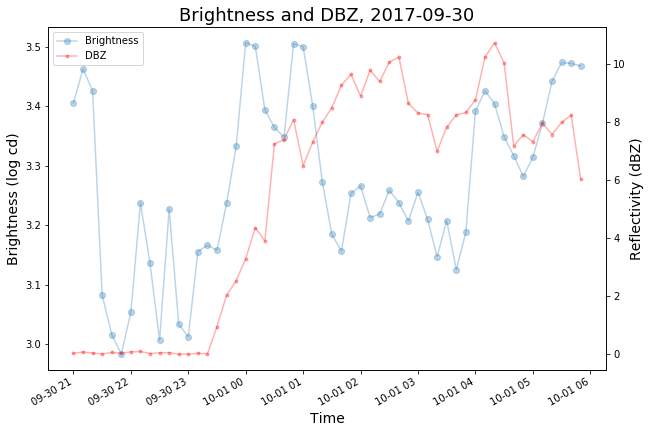

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fancy_plot(mgd)

/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


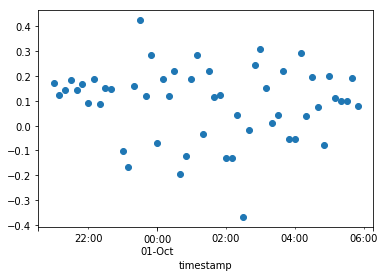

In [19]:
mgd.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot(style='o')

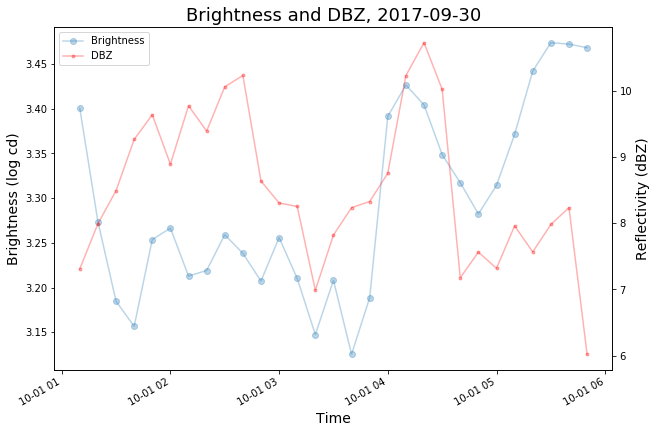

0.0651956979888665

In [20]:
after_begins = (mgd['timestamp'] > '{} 01:00:00'.format(next_night))
fancy_plot(mgd[after_begins])
np.corrcoef(mgd[after_begins]["dbzh"], mgd[after_begins]["z"])[0,1]

In [21]:
ma = mgd[after_begins].groupby("timestamp")[["dbzh", "z"]].mean()
from sklearn.preprocessing import StandardScaler
dbz = StandardScaler().fit_transform(ma["dbzh"].values.reshape(-1, 1))
bgd = StandardScaler().fit_transform(ma["z"].values.reshape(-1, 1))
np.corrcoef(bgd[:, 0], dbz[:, 0])[1, 0]

-0.1340931642154312

### Now, filter only over manhattan

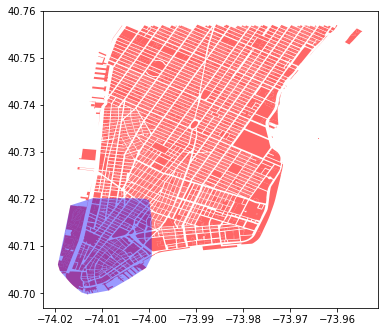

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(6, 11))

krige.in_frame.plot(ax=ax, color='red', alpha=.6)
filt = (krige.out_reset.geometry.centroid.x > -74.03) & (krige.out_reset.geometry.centroid.y > 40.7)
krige.out_reset[filt].plot(ax=ax, color='red', alpha=.6)

infilt = (krige.in_frame.geometry.centroid.y < 40.72) & (krige.in_frame.geometry.centroid.x < -74) 
outfilt2 = (krige.out_reset.geometry.centroid.y < 40.72) & (krige.out_reset.geometry.centroid.x < -74)
ch = gpd.GeoSeries(pd.concat([krige.in_frame[infilt].geometry, 
                              krige.out_reset[filt & outfilt2].geometry])).unary_union.convex_hull
gpd.GeoSeries([ch]).plot(ax=ax, color='blue', alpha=.4)


In [23]:
ch_df = gpd.GeoDataFrame({"geometry": gpd.GeoSeries([ch])})

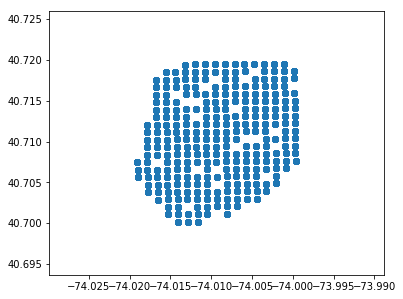

In [24]:
import shapely.geometry
mgd["geometry"] = mgd[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
mgd = gpd.GeoDataFrame(mgd)
if 'index_left' in mgd:
    del mgd["index_left"]
if 'index_right' in mgd:
    del mgd["index_right"]
joined = gpd.sjoin(mgd, ch_df)
fig, ax = plt.subplots(1, 1, figsize=(6, 11))
joined.plot(ax=ax)

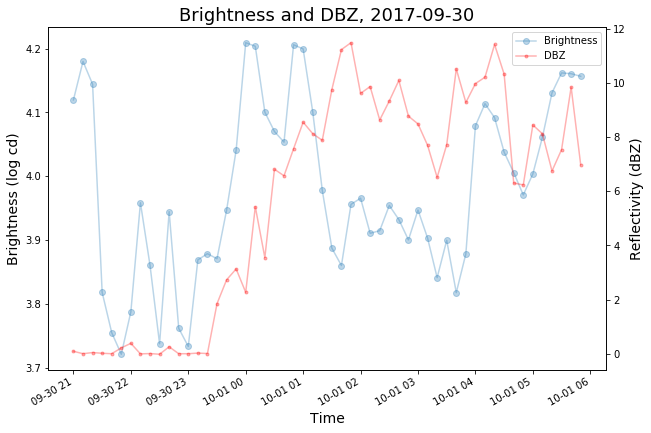

In [25]:
fancy_plot(joined)

In [26]:
after_begins = (joined['timestamp'] > '{} 01:00:00'.format(next_night))

ma = joined[after_begins].groupby("timestamp")[["dbzh", "z"]].mean()
from sklearn.preprocessing import StandardScaler
dbz = StandardScaler().fit_transform(ma["dbzh"].values.reshape(-1, 1))
bgd = StandardScaler().fit_transform(ma["z"].values.reshape(-1, 1))
np.corrcoef(bgd[:, 0], dbz[:, 0])[1, 0]

-0.13652636222707432

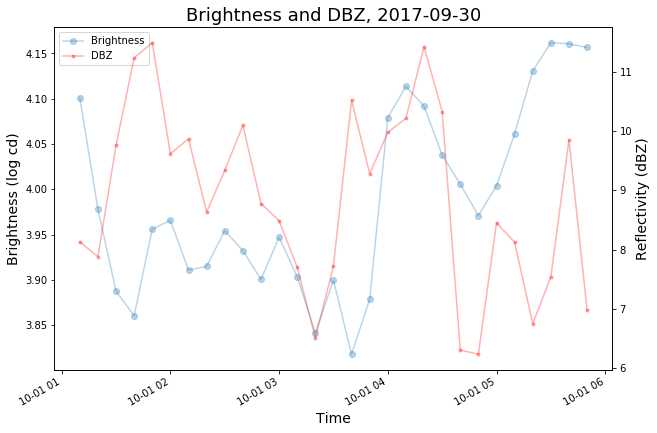

In [27]:
fancy_plot(joined[after_begins])